# Plate → Text Split Pipeline

Load plate detector and plate splitter weights, run two-stage inference, and display bounding boxes/positions for each step.


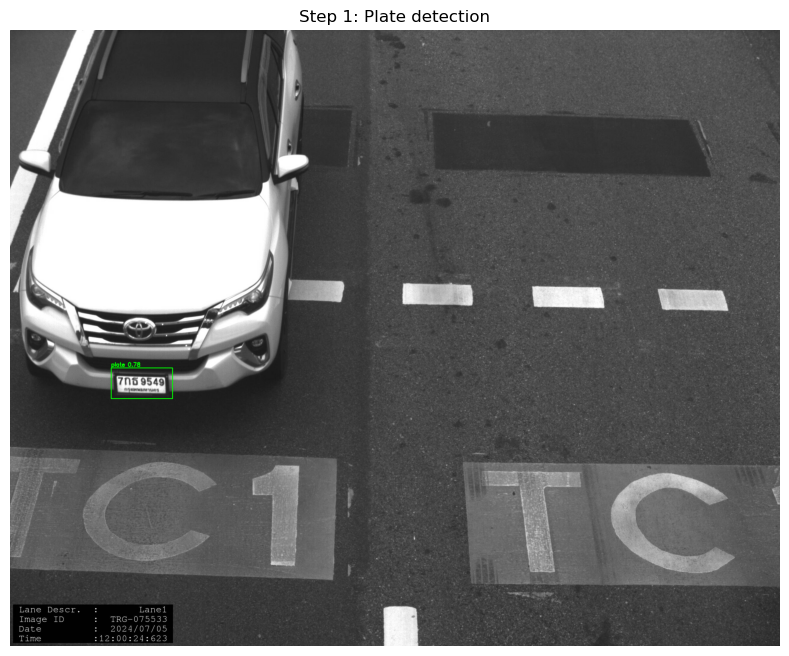

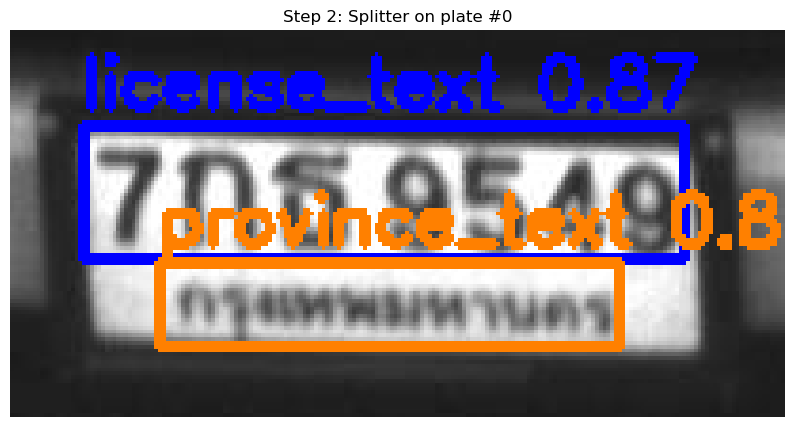

Plate 0 | license_text 0.87 | box=(19,25)-(177,60)
Plate 0 | province_text 0.82 | box=(39,61)-(160,83)
Plate detector time: 186.5 ms
Splitter time (plate 0): 87.0 ms
Avg splitter time: 87.0 ms


In [6]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Paths to weights (update if moved)
WEIGHTS_DIR = Path(r"C:\Users\Tanaphat\Desktop\Coding\ALPR\weights")
PLATE_DET_W = WEIGHTS_DIR / "plate_detector_best.pt"
PLATE_SPLIT_W = WEIGHTS_DIR / "plate_splitter_best.pt"

# Load models
plate_model = YOLO(PLATE_DET_W)  # plate detector (YOLOv11s)
splitter_model = YOLO(PLATE_SPLIT_W)  # plate splitter (YOLOv11n)

# Colors per class for splitter
SPLIT_COLORS = {0: (255, 0, 0), 1: (0, 128, 255)}  # BGR: license_text red-ish, province orange

def load_bgr(path: Path):
    img = cv2.imdecode(np.fromfile(str(path), dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {path}")
    return img

def draw_boxes(img_bgr, boxes, labels=None, color=(0, 255, 0), thickness=2):
    img = img_bgr.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels:
            cv2.putText(img, labels[i], (x1, max(0, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

# --- User image ---
IMG_PATH = Path(r"C:\Users\Tanaphat\Desktop\Coding\ALPR\data\8000\210\2024-07-05\12\Lane1\2024-07-05_12-00-24-623_TRG-075533_Lane1_7กธ9549-THA_10.jpg")  # change to your input
frame = load_bgr(IMG_PATH)

# Step 1: Plate detection (timed)
t0 = time.perf_counter()
plate_results = plate_model.predict(frame, conf=0.25, iou=0.7, imgsz=1280, verbose=False)[0]
plate_time = time.perf_counter() - t0
plate_boxes = plate_results.boxes.xyxy.cpu().numpy() if plate_results.boxes is not None else []
plate_confs = plate_results.boxes.conf.cpu().numpy() if plate_results.boxes is not None else []
plate_labels = [f"plate {c:.2f}" for c in plate_confs] if len(plate_confs) else []
vis_plate = draw_boxes(frame, plate_boxes, plate_labels, color=(0, 255, 0))

# Step 2: For each detected plate, run splitter (timed per plate)
split_viz_list = []
split_times = []
for idx, box in enumerate(plate_boxes):
    x1, y1, x2, y2 = map(int, box)
    plate_crop = frame[y1:y2, x1:x2]
    if plate_crop.size == 0:
        continue
    t1 = time.perf_counter()
    split_res = splitter_model.predict(plate_crop, conf=0.25, iou=0.6, imgsz=640, verbose=False)[0]
    split_time = time.perf_counter() - t1
    split_times.append((idx, split_time))
    split_boxes = split_res.boxes.xyxy.cpu().numpy() if split_res.boxes is not None else []
    split_cls = split_res.boxes.cls.cpu().numpy().astype(int) if split_res.boxes is not None else []
    split_confs = split_res.boxes.conf.cpu().numpy() if split_res.boxes is not None else []
    labels = []
    colors = []
    for c, s in zip(split_cls, split_confs):
        name = splitter_model.names.get(int(c), str(int(c)))
        labels.append(f"{name} {s:.2f}")
        colors.append(SPLIT_COLORS.get(int(c), (255, 255, 0)))
    crop_viz = plate_crop.copy()
    for b, lbl, clr in zip(split_boxes, labels, colors):
        x1s, y1s, x2s, y2s = map(int, b)
        cv2.rectangle(crop_viz, (x1s, y1s), (x2s, y2s), clr, 2)
        cv2.putText(crop_viz, lbl, (x1s, max(0, y1s - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, clr, 2)
    split_viz_list.append((idx, crop_viz, split_boxes, labels))

# --- Visualization ---
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(vis_plate, cv2.COLOR_BGR2RGB))
plt.title("Step 1: Plate detection")
plt.axis('off')
plt.show()

if not split_viz_list:
    print("No plates found; adjust confidence or check input image path.")
else:
    for idx, crop_viz, s_boxes, s_labels in split_viz_list:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(crop_viz, cv2.COLOR_BGR2RGB))
        plt.title(f"Step 2: Splitter on plate #{idx}")
        plt.axis('off')
        plt.show()
        # Print positions
        for b, lbl in zip(s_boxes, s_labels):
            x1, y1, x2, y2 = map(int, b)
            print(f"Plate {idx} | {lbl} | box=({x1},{y1})-({x2},{y2})")

# --- Timing summary ---
print(f"Plate detector time: {plate_time*1000:.1f} ms")
for idx, st in split_times:
    print(f"Splitter time (plate {idx}): {st*1000:.1f} ms")
if split_times:
    avg_split = sum(st for _, st in split_times) / len(split_times)
    print(f"Avg splitter time: {avg_split*1000:.1f} ms")